In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, dual_annealing, differential_evolution

from plot import plot_results

# Project: One-Mass Oscillator Optimization

## Introduction

In this project, various optimization algorithms will be applied to fit a one-mass oscillator model to real-world data. The objective is to minimize the sum of the squared residuals between the model predictions and the observed amplitudes of a one-mass oscillator system across different frequencies.

### One-Mass Oscillator Model

The one-mass oscillator is characterized by the following equation, representing the amplitudes of the system:

$$ V(\omega) = \frac{F}{\sqrt{(1 - \nu^2)^2 + 4D^2\nu^2}} $$

Here, 
- $ \omega $ represents the angular frequency of the system,
- $ \nu $ is the ratio of the excitation frequency to the natural frequency ($ \nu = \frac{\omega_{\text{err}}}{\omega_{\text{eig}}} $),
- $ D $ is the damping ratio,
- $ F $ is the force applied to the system.

The goal of the project is to determine the optimal values for the parameters $ \omega_{\text{eig}} $, $ D $, and $ F $ that result in the best fit of the one-mass oscillator model to the observed amplitudes.

### Load the real world data

- we have two different measurements
- J represents the measured frequencies
- N represents the measured amplitudes

In [2]:
df1 = pd.read_pickle("./data/df1.pkl")
df2 = pd.read_pickle("./data/df2.pkl")

### Low amplitudes distort the fit and are negligible therefore we define a lower threshold for N

In [3]:
# Define maximum threshold for removing low amplitudes
max_threshold = 0.4 * max(df1["N"])

# Remove the low amplitude entries to avoid distortion in fitting
df1 = df1[df1["N"]>=max_threshold]
df2 = df2[df2["N"]>=max_threshold]

### We extract the frequency value for maximum value of the amplitude. This serves as the initial value for one decision variable

In [4]:
df1_max = df1[df1["N"]==max(df1["N"])]
df1_initial_eig = df1_max["J"].values[0]
df1_max_N = df1_max["N"].values[0]

df2_max = df2[df2["N"]==max(df2["N"])]
df2_initial_eig = df2_max["J"].values[0]
df2_max_N = df2_max["N"].values[0]

### We also have to define the other two initial guesses

In [5]:
# Initial guesses of force and damping ratio values
initial_D = 0.006
initial_F = 0.120

df1_initial_values = [df1_initial_eig, initial_D, initial_F]
df2_initial_values = [df2_initial_eig, initial_D, initial_F]

### Additionally we define the bounds for the decision variables

In [6]:
# Define minimum and maximum frequency values for boundary condition
df1_min_J = min(df1["J"])
df1_max_J = max(df1["J"])

df2_min_J = min(df2["J"])
df2_max_J = max(df2["J"])

In [7]:
df1_bounds = [(df1_min_J, df1_max_J), (0, 0.03), (0, 1)]
df2_bounds = [(df2_min_J, df2_max_J), (0, 0.03), (0, 1)]

### Then we define our one mass oscialltor and objective function

In [8]:
def one_mass_oscillator(params, J) -> np.ndarray:
    # returns amplitudes of the system
    # Defines the model of a one mass oscilator 
    eig, D, F = params
    nue = J / eig
    V = F / (np.sqrt((1 - nue**2) ** 2 + (4 * D**2 * nue**2)))
    return V

In [9]:
def objective_function(params, J, N) -> np.ndarray:
    # sum of squared errors to compare calculated and real amplitudes
    return np.sum((N - one_mass_oscillator(params, J)) ** 2)

### Define gradient function of objective function for optimizers that require gradient matrix 

In [10]:
def gradient(params, J, N):
    eig, D, F = params
    nue = J / eig

    df = N - one_mass_oscillator(params, J)
    u = (1 - nue**2) ** 2 + (4 * D**2 * nue**2)
    dudeig = (4 * nue**2 * (1 - nue**2 - 2 * D**2)) / eig
    
    dfdF = np.sum((-2 * df) / np.sqrt(u))
    dfdD = np.sum((8 * df * F * D * nue**2) / np.sqrt(u ** 3))
    dfdeig = np.sum((F * dudeig * df) / np.sqrt(u ** 3))

    return np.array([dfdeig, dfdD, dfdF])

### Define hessian function of objective function for optimizers that require hessian matrix 

In [11]:
def hessian(params, J, N):
    eig, D, F = params
    nue = J / eig

    u = (1 - nue**2) ** 2 + (4 * D**2 * nue**2)
    dudeig = (4 * nue**2 * (1 - nue**2 - 2 * D**2)) / eig
    dudD = 8 * nue**2 * D
    d2udeig = (4 * nue**2 * (5 - 3 * nue**2 - 6 * D**2)) / eig**2
    
    d2fdF = np.sum(2 / u)
    d2fdFD = np.sum((dudD * (np.sqrt(u) * N - 2 * F)) / u ** 2)
    d2fdFeig = np.sum((dudeig * (np.sqrt(u) * N  - 2 * F)) / u ** 2)
    d2fdDF = d2fdFD
    d2fdD = np.sum((8 * nue**2 * F / u**2) * ((N * np.sqrt(u) - F) + ((dudD * D) / u) * (2 * F - 1.5 * np.sqrt(u) * N)))
    d2fdDeig = np.sum((dudD * F / u**2) * (((dudeig / u) * (2 * F - 1.5 * np.sqrt(u) * N)) - ((2 / eig) * (N * np.sqrt(u) - F))))
    d2fdeigF = d2fdFeig
    d2fdeigD = d2fdDeig
    d2fdeig = np.sum((F / u**2) * ((d2udeig * (N * np.sqrt(u) - F)) - ((dudeig**2 / u) * (2 * F - 1.5 * np.sqrt(u) * N))))

    return np.array([[d2fdeig, d2fdeigD, d2fdeigF], [d2fdDeig, d2fdD, d2fdDF], [d2fdFeig, d2fdFD, d2fdF]])

### Extract the frequency and amplitude from the dataframes

In [12]:
df1_J = np.array(df1["J"])
df1_N = np.array(df1["N"])

df2_J = np.array(df2["J"])
df2_N = np.array(df2["N"])

### Generate the frequencies to fit the one mass oscillator

In [13]:
df1_J_pred = np.linspace(df1_min_J, df1_max_J, 1000)
df2_J_pred = np.linspace(df2_min_J, df2_max_J, 1000)

### Define the options and start the optimizations (Nelder-Mead)

In [14]:
options = {
    "maxiter": 100000,
    "fatol": 1e-9,
    "xatol": 1e-9,
}

df1_result = minimize(objective_function, df1_initial_values, args=(df1_J, df1_N), method='Nelder-Mead', bounds=df1_bounds, options=options)
df2_result = minimize(objective_function, df2_initial_values, args=(df2_J, df2_N), method='Nelder-Mead', bounds=df2_bounds, options=options)
print(df1_result)
print(df2_result)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 53.541440589599794
             x: [ 8.148e+03  7.435e-04  2.153e-02]
           nit: 141
          nfev: 274
 final_simplex: (array([[ 8.148e+03,  7.435e-04,  2.153e-02],
                       [ 8.148e+03,  7.435e-04,  2.153e-02],
                       [ 8.148e+03,  7.435e-04,  2.153e-02],
                       [ 8.148e+03,  7.435e-04,  2.153e-02]]), array([ 5.354e+01,  5.354e+01,  5.354e+01,  5.354e+01]))
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 393.21343352831644
             x: [ 8.145e+03  7.700e-04  5.083e-02]
           nit: 157
          nfev: 315
 final_simplex: (array([[ 8.145e+03,  7.700e-04,  5.083e-02],
                       [ 8.145e+03,  7.700e-04,  5.083e-02],
                       [ 8.145e+03,  7.700e-04,  5.083e-02],
                       [ 8.145e+03,  7.700e-04,  5.083e-02]]), array([ 3.9

In [15]:
df1_resonant_frequency = df1_result.x[0]

df1_one_mass_oscillator = one_mass_oscillator(df1_result.x, df1_J_pred)
df1_resonant_amplitude = max(df1_one_mass_oscillator)

df2_resonant_frequency = df2_result.x[0]

df2_one_mass_oscillator = one_mass_oscillator(df2_result.x, df2_J_pred)
df2_resonant_amplitude = max(df2_one_mass_oscillator)

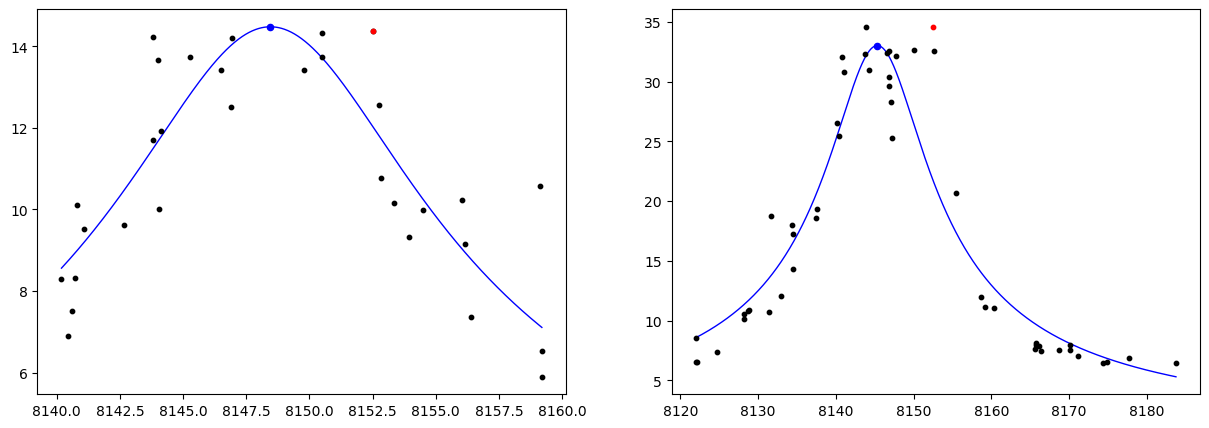

In [16]:
plot_results(
    [df1,df2], 
    [df1_initial_eig, df1_initial_eig], 
    [df1_max_N, df2_max_N], 
    [df1_J_pred, df2_J_pred], 
    [df1_one_mass_oscillator, df2_one_mass_oscillator],
    [df1_resonant_frequency, df2_resonant_frequency],
    [df1_resonant_amplitude, df2_resonant_amplitude]
)

### Optimizing with Powell's method

In [17]:
options = {
    "maxiter": 100000,
    "ftol": 1e-9,
    "xtol": 1e-9,
}

df1_result = minimize(objective_function, df1_initial_values, args=(df1_J, df1_N), method='Powell', bounds=df1_bounds, options=options)
df2_result = minimize(objective_function, df2_initial_values, args=(df2_J, df2_N), method='Powell', bounds=df2_bounds, options=options)
print(df1_result)
print(df2_result)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 53.54144059016111
       x: [ 8.148e+03  7.435e-04  2.153e-02]
     nit: 11
   direc: [[ 1.978e+00 -1.935e-03 -3.893e-02]
           [-1.091e+00 -1.473e-05 -1.175e-04]
           [ 5.034e-08  6.736e-10 -1.229e-08]]
    nfev: 693
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 393.2134335394193
       x: [ 8.145e+03  7.700e-04  5.083e-02]
     nit: 8
   direc: [[-4.019e-01 -3.341e-05 -2.096e-03]
           [ 0.000e+00  0.000e+00  1.000e+00]
           [ 2.223e-03 -3.571e-07 -1.810e-05]]
    nfev: 511


In [18]:
df1_resonant_frequency = df1_result.x[0]

df1_one_mass_oscillator = one_mass_oscillator(df1_result.x, df1_J_pred)
df1_resonant_amplitude = max(df1_one_mass_oscillator)

df2_resonant_frequency = df2_result.x[0]

df2_one_mass_oscillator = one_mass_oscillator(df2_result.x, df2_J_pred)
df2_resonant_amplitude = max(df2_one_mass_oscillator)

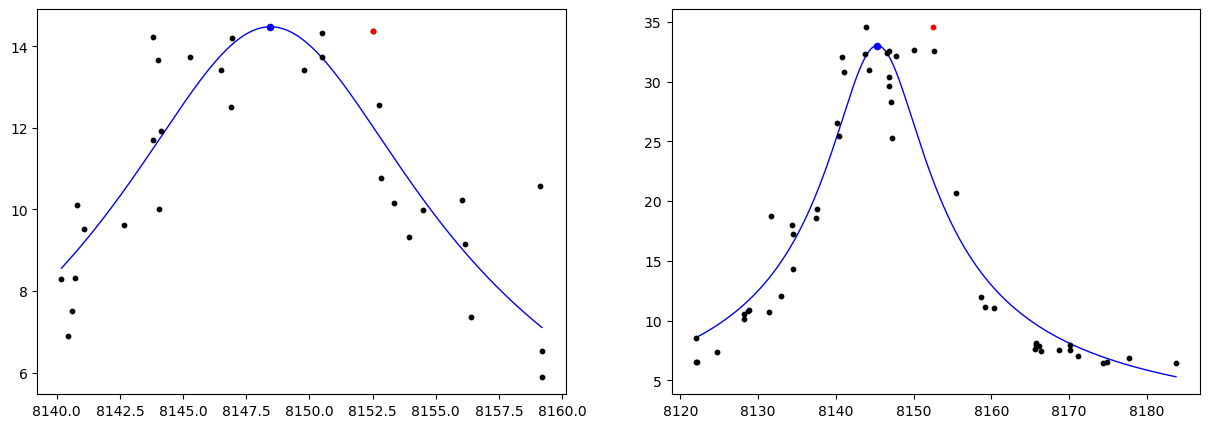

In [19]:
plot_results(
    [df1,df2], 
    [df1_initial_eig, df1_initial_eig], 
    [df1_max_N, df2_max_N], 
    [df1_J_pred, df2_J_pred], 
    [df1_one_mass_oscillator, df2_one_mass_oscillator],
    [df1_resonant_frequency, df2_resonant_frequency],
    [df1_resonant_amplitude, df2_resonant_amplitude]
)

### Optimizing with CG method

In [20]:
options = {
    "maxiter": 100000,
    "gtol": 1e-8,
}

df1_result = minimize(objective_function, df1_initial_values, args=(df1_J, df1_N), method='CG', jac=gradient, options=options)
df2_result = minimize(objective_function, df2_initial_values, args=(df2_J, df2_N), method='CG', jac=gradient, options=options)
print(df1_result)
print(df2_result)

 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 53.54145215063091
       x: [ 8.148e+03  7.435e-04  2.153e-02]
     nit: 566
     jac: [-2.870e-02  3.509e-02  4.152e-03]
    nfev: 1340
    njev: 1328
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 393.2134793288537
       x: [ 8.145e+03  7.700e-04  5.083e-02]
     nit: 258
     jac: [-8.941e-02 -1.558e+00  1.607e-01]
    nfev: 790
    njev: 779


In [21]:
df1_resonant_frequency = df1_result.x[0]

df1_one_mass_oscillator = one_mass_oscillator(df1_result.x, df1_J_pred)
df1_resonant_amplitude = max(df1_one_mass_oscillator)

df2_resonant_frequency = df2_result.x[0]

df2_one_mass_oscillator = one_mass_oscillator(df2_result.x, df2_J_pred)
df2_resonant_amplitude = max(df2_one_mass_oscillator)

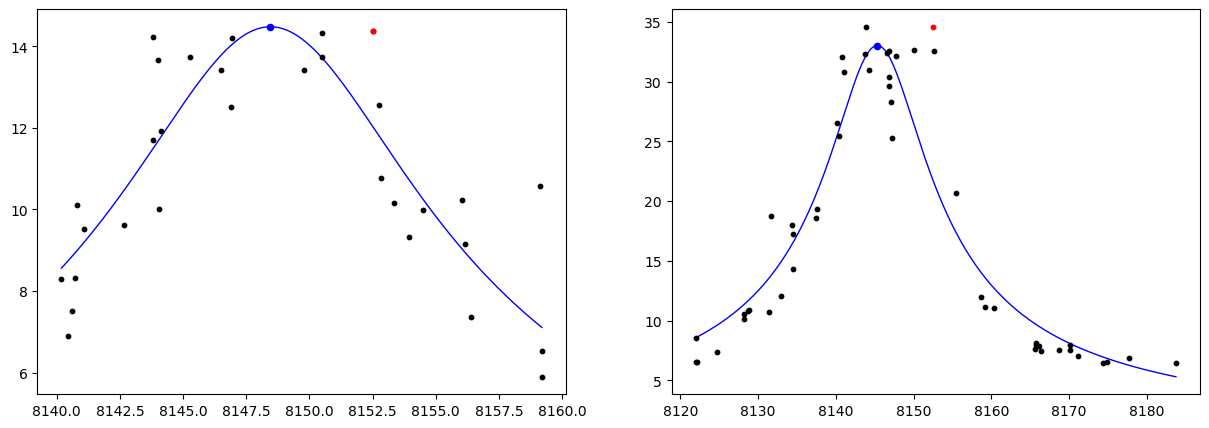

In [22]:
plot_results(
    [df1,df2], 
    [df1_initial_eig, df1_initial_eig], 
    [df1_max_N, df2_max_N], 
    [df1_J_pred, df2_J_pred], 
    [df1_one_mass_oscillator, df2_one_mass_oscillator],
    [df1_resonant_frequency, df2_resonant_frequency],
    [df1_resonant_amplitude, df2_resonant_amplitude]
)

### Optimizing with BFGS method

In [23]:
options = {
    "maxiter": 100000,
    "gtol": 1e-5,
}

df1_result = minimize(objective_function, df1_initial_values, args=(df1_J, df1_N), method='BFGS', jac=gradient, options=options)
df2_result = minimize(objective_function, df2_initial_values, args=(df2_J, df2_N), method='BFGS', jac=gradient, options=options)
print(df1_result)
print(df2_result)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 53.54144058960491
        x: [ 8.148e+03  7.435e-04  2.153e-02]
      nit: 21
      jac: [ 4.192e-08  4.174e-04 -1.157e-05]
 hess_inv: [[ 2.755e-02  6.694e-08  3.386e-06]
            [ 6.694e-08  1.519e-09  2.916e-08]
            [ 3.386e-06  2.916e-08  6.199e-07]]
     nfev: 85
     njev: 73
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 393.2134335283437
        x: [ 8.145e+03  7.700e-04  5.083e-02]
      nit: 16
      jac: [-9.178e-12  3.178e-08  4.107e-09]
 hess_inv: [[ 1.155e-02  4.390e-07  2.156e-05]
            [ 4.390e-07  1.522e-10  6.937e-09]
            [ 2.156e-05  6.937e-09  3.845e-07]]
     nfev: 79
     njev: 76


In [24]:
df1_resonant_frequency = df1_result.x[0]

df1_one_mass_oscillator = one_mass_oscillator(df1_result.x, df1_J_pred)
df1_resonant_amplitude = max(df1_one_mass_oscillator)

df2_resonant_frequency = df2_result.x[0]

df2_one_mass_oscillator = one_mass_oscillator(df2_result.x, df2_J_pred)
df2_resonant_amplitude = max(df2_one_mass_oscillator)

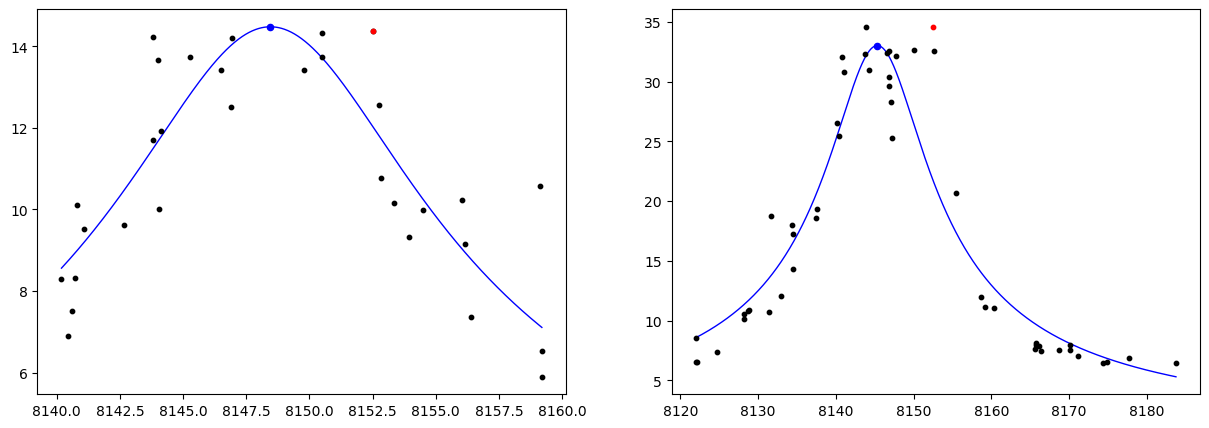

In [25]:
plot_results(
    [df1,df2], 
    [df1_initial_eig, df1_initial_eig], 
    [df1_max_N, df2_max_N], 
    [df1_J_pred, df2_J_pred], 
    [df1_one_mass_oscillator, df2_one_mass_oscillator],
    [df1_resonant_frequency, df2_resonant_frequency],
    [df1_resonant_amplitude, df2_resonant_amplitude]
)

### Optimizing with Newton-CG method

In [26]:
options = {
    "maxiter": 100000,
    "xtol": 1e-9,
}

df1_result = minimize(objective_function, df1_initial_values, args=(df1_J, df1_N), method='Newton-CG', jac=gradient, hess=hessian, options=options)
df2_result = minimize(objective_function, df2_initial_values, args=(df2_J, df2_N), method='Newton-CG', jac=gradient, hess=hessian, options=options)
print(df1_result)
print(df2_result)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 53.541440592077144
       x: [ 8.148e+03  7.435e-04  2.153e-02]
     nit: 78916
     jac: [ 4.193e-04 -6.737e-06  2.130e-06]
    nfev: 78927
    njev: 78927
    nhev: 78916
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 393.21343364916567
       x: [ 8.145e+03  7.700e-04  5.083e-02]
     nit: 18616
     jac: [-4.580e-03 -2.612e-04  9.257e-06]
    nfev: 18635
    njev: 18635
    nhev: 18616


In [27]:
df1_resonant_frequency = df1_result.x[0]

df1_one_mass_oscillator = one_mass_oscillator(df1_result.x, df1_J_pred)
df1_resonant_amplitude = max(df1_one_mass_oscillator)

df2_resonant_frequency = df2_result.x[0]

df2_one_mass_oscillator = one_mass_oscillator(df2_result.x, df2_J_pred)
df2_resonant_amplitude = max(df2_one_mass_oscillator)

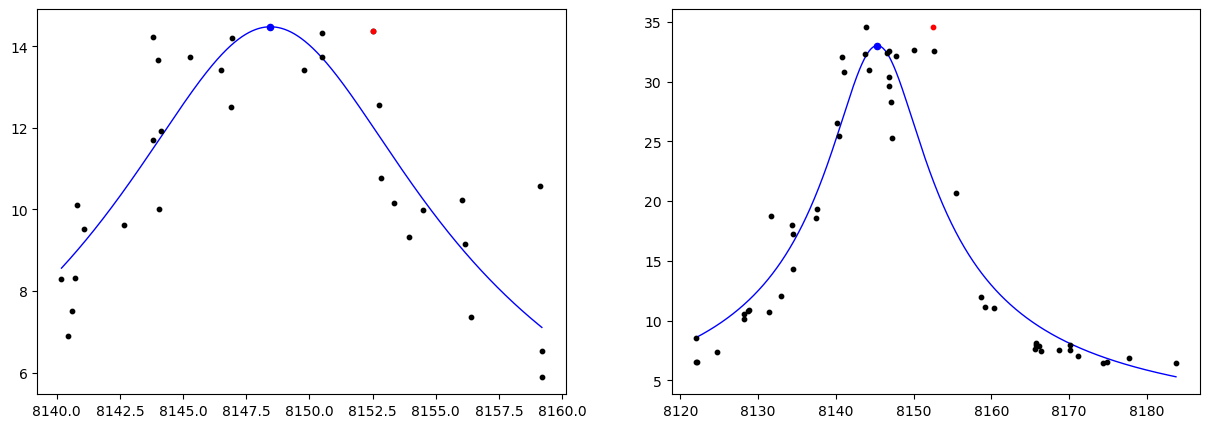

In [28]:
plot_results(
    [df1,df2], 
    [df1_initial_eig, df1_initial_eig], 
    [df1_max_N, df2_max_N], 
    [df1_J_pred, df2_J_pred], 
    [df1_one_mass_oscillator, df2_one_mass_oscillator],
    [df1_resonant_frequency, df2_resonant_frequency],
    [df1_resonant_amplitude, df2_resonant_amplitude]
)

### Optimizing with Simulated Annealing

In [29]:
df1_result = dual_annealing(objective_function, x0=df1_initial_values, args=(df1_J, df1_N), bounds=df1_bounds, maxiter=50)
df2_result = dual_annealing(objective_function, x0=df2_initial_values, args=(df2_J, df2_N), bounds=df2_bounds, maxiter=50)
print(df1_result)
print(df2_result)

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 53.54144147227184
       x: [ 8.148e+03  7.434e-04  2.153e-02]
     nit: 50
    nfev: 465
    njev: 41
    nhev: 0
 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 393.213435620241
       x: [ 8.145e+03  7.700e-04  5.083e-02]
     nit: 50
    nfev: 469
    njev: 42
    nhev: 0


In [30]:
df1_resonant_frequency = df1_result.x[0]

df1_one_mass_oscillator = one_mass_oscillator(df1_result.x, df1_J_pred)
df1_resonant_amplitude = max(df1_one_mass_oscillator)

df2_resonant_frequency = df2_result.x[0]

df2_one_mass_oscillator = one_mass_oscillator(df2_result.x, df2_J_pred)
df2_resonant_amplitude = max(df2_one_mass_oscillator)

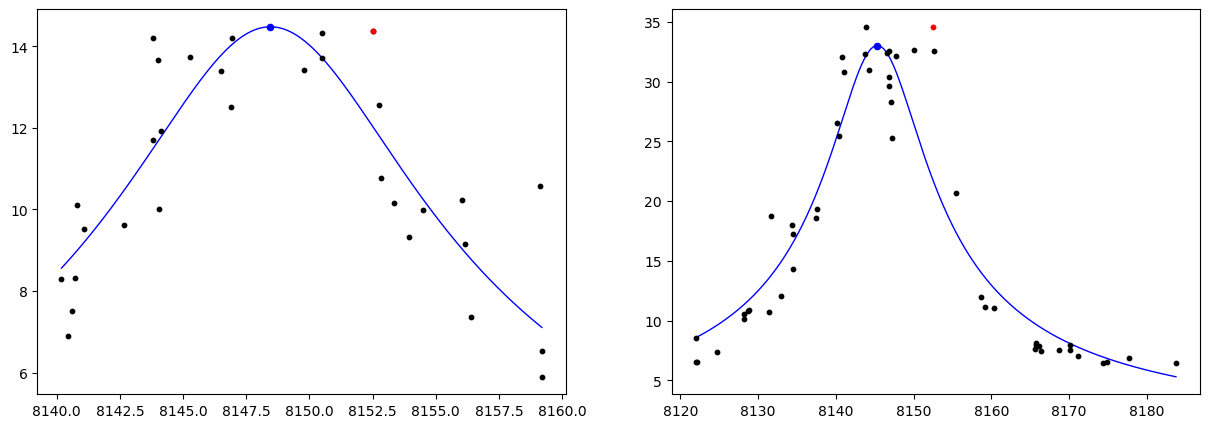

In [31]:
plot_results(
    [df1,df2], 
    [df1_initial_eig, df1_initial_eig], 
    [df1_max_N, df2_max_N], 
    [df1_J_pred, df2_J_pred], 
    [df1_one_mass_oscillator, df2_one_mass_oscillator],
    [df1_resonant_frequency, df2_resonant_frequency],
    [df1_resonant_amplitude, df2_resonant_amplitude]
)

### Optimizing with Differential Evolution

In [32]:
df1_result = differential_evolution(objective_function, x0=df1_initial_values, args=(df1_J, df1_N), bounds=df1_bounds, maxiter=50)
df2_result = differential_evolution(objective_function, x0=df2_initial_values, args=(df2_J, df2_N), bounds=df2_bounds, maxiter=50)
print(df1_result)
print(df2_result)

             message: Optimization terminated successfully.
             success: True
                 fun: 53.55317044092296
                   x: [ 8.148e+03  7.435e-04  2.153e-02]
                 nit: 37
                nfev: 1782
          population: [[ 8.148e+03  7.445e-04  2.151e-02]
                       [ 8.149e+03  7.590e-04  2.192e-02]
                       ...
                       [ 8.148e+03  7.506e-04  2.175e-02]
                       [ 8.149e+03  7.530e-04  2.163e-02]]
 population_energies: [ 5.355e+01  5.396e+01 ...  5.362e+01  5.467e+01]
                 jac: [ 9.141e-01 -2.381e+00  1.027e+00]
             message: Optimization terminated successfully.
             success: True
                 fun: 393.23385545638666
                   x: [ 8.145e+03  7.708e-04  5.087e-02]
                 nit: 35
                nfev: 1660
          population: [[ 8.145e+03  7.682e-04  5.073e-02]
                       [ 8.145e+03  7.642e-04  5.063e-02]
                      

In [33]:
df1_resonant_frequency = df1_result.x[0]

df1_one_mass_oscillator = one_mass_oscillator(df1_result.x, df1_J_pred)
df1_resonant_amplitude = max(df1_one_mass_oscillator)

df2_resonant_frequency = df2_result.x[0]

df2_one_mass_oscillator = one_mass_oscillator(df2_result.x, df2_J_pred)
df2_resonant_amplitude = max(df2_one_mass_oscillator)

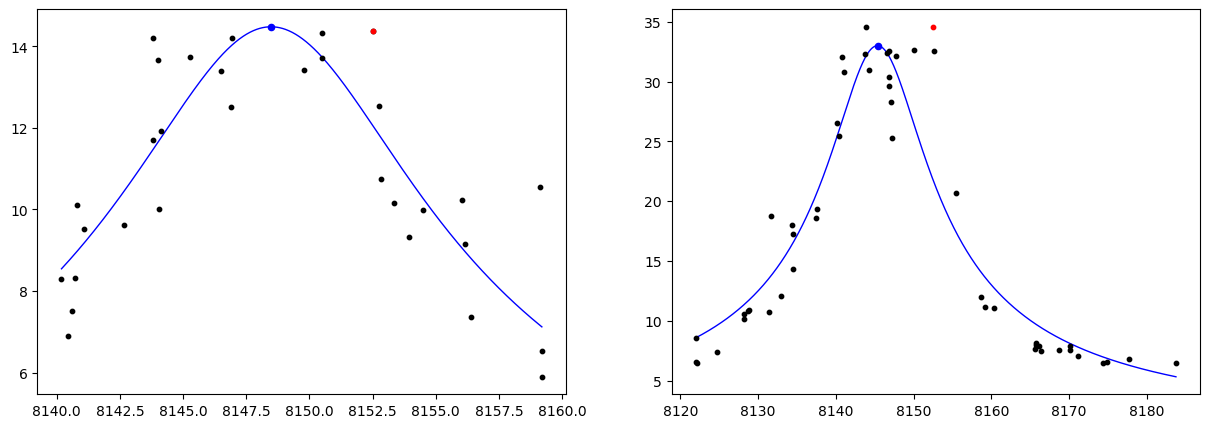

In [34]:
plot_results(
    [df1,df2], 
    [df1_initial_eig, df1_initial_eig], 
    [df1_max_N, df2_max_N], 
    [df1_J_pred, df2_J_pred], 
    [df1_one_mass_oscillator, df2_one_mass_oscillator],
    [df1_resonant_frequency, df2_resonant_frequency],
    [df1_resonant_amplitude, df2_resonant_amplitude]
)